In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize.casual import casual_tokenize

from gensim.parsing.preprocessing import preprocess_documents, preprocess_string
from gensim.models.phrases import Phraser
from gensim.models import Phrases
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

import multiprocessing

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load data

In [5]:
df_neg = pd.read_csv('data/processedNegative.csv').T
df_neutral = pd.read_csv('data/processedNeutral.csv').T
df_positive = pd.read_csv('data/processedPositive.csv').T

In [6]:
df_neg['sentiment'] = [-1 for i in range(df_neg.shape[0])]
df_neutral['sentiment'] = [0 for i in range(df_neutral.shape[0])]
df_positive['sentiment'] = [1 for i in range(df_positive.shape[0])]

# Join data

In [7]:
df = pd.concat([df_neg, df_neutral, df_positive]).reset_index()
df.rename(columns={'index': 'text'}, inplace=True)
df

,text,sentiment
0,How unhappy some dogs like it though,-1
1,talking to my over driver about where I'm goin...,-1
2,Does anybody know if the Rand's likely to fall...,-1
3,I miss going to gigs in Liverpool unhappy,-1
4,There isnt a new Riverdale tonight ? unhappy,-1
...,...,...
3868,Thanks for the recent follow Happy to connect ...,1
3869,- top engaged members this week happy,1
3870,ngam to weeks left for cadet pilot exam cryin...,1
3871,Great! You're welcome Josh happy ^Adam,1


# Look at data in graph

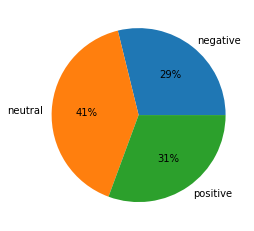

In [8]:
num_negative = df_neg.shape[0]
num_neutral = df_neutral.shape[0]
num_positive = df_positive.shape[0]
plt.pie([num_negative, num_neutral, num_positive], labels=['negative', 'neutral', 'positive'], autopct='%.0f%%')
None

#Top 10 similar

In [9]:
def cosine_sim(vec1, vec2):
  dot_prod = 0
  for i, v in enumerate(vec1):
    dot_prod += v * vec2[i]
  mag_1 = math.sqrt(sum([x**2 for x in vec1]))
  mag_2 = math.sqrt(sum([x**2 for x in vec2]))
  return dot_prod / (mag_1 * mag_2)


def top10(data_vectors, tweet_id):
  vec1 = data_vectors[tweet_id]
  cosines = []
  for id, vector in enumerate(data_vectors):
    if tweet_id != id:
      cosines.append({'id': id, 'val': cosine_sim(vec1, vector)})
  res = sorted(cosines, key=lambda d: d['val'], reverse=True)
  return res[:10]

# Just tokenization

In [10]:
def tokenize_doc(doc):
  return [casual_tokenize(text) for text in doc]

def normalization(tokenize_doc):
  return [[token.lower() for token in tokens] for tokens in tokenize_doc]

def remove_stopwords(tokenize_doc):
  stop_words = stopwords.words('english')
  return [[token for token in tokens if token not in stop_words] for tokens in tokenize_doc]

def make_bigrams(tokenize_doc):
  bigrams_phrases = Phrases(tokenize_doc)
  bigram = Phraser(bigrams_phrases)
  doc_bigram = [bigram[text] for text in tokenize_doc]
  return doc_bigram

FILTERS = [tokenize_doc, normalization, remove_stopwords, make_bigrams]

def preprocessing_doc(doc, filters=FILTERS):
  for f in filters:
    doc = f(doc)
  return doc

## One hot

In [11]:
def onehot_vectorize(doc):
  doc_seq = preprocessing_doc(doc)
  vocab = set()
  for token_seq in doc_seq:
    for word in token_seq:
      vocab.add(word)
  vocab = sorted(vocab)
  vocab_size = len(vocab)
  onehot_vectors = np.zeros((len(doc), vocab_size), int)
  for token_sequence in doc_seq:
    for i, word in enumerate(token_sequence):
      onehot_vectors[i, vocab.index(word)] = 1
  return onehot_vectors


### Split data on test and train parts 

In [12]:
df_onehot = onehot_vectorize(df['text'])
X_train_onehot, X_test_onehot, y_train, y_test = train_test_split(df_onehot, df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

### Naive Bayes

In [13]:
from sklearn.naive_bayes import MultinomialNB

MNB_onehot = MultinomialNB()
MNB_onehot.fit(X_train_onehot, y_train)
mnb_onehot_pred = MNB_onehot.predict(X_test_onehot)
print(f'accuracy: {accuracy_score(y_test, mnb_onehot_pred)}')

accuracy: 0.40903225806451615


### KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

KNN_onehot = KNeighborsClassifier()
KNN_onehot.fit(X_train_onehot, y_train)
KNN_onehot_pred = KNN_onehot.predict(X_test_onehot)
print(f'accuracy: {accuracy_score(y_test, KNN_onehot_pred)}')

accuracy: 0.40903225806451615


### Random forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

RF_onehot = RandomForestClassifier()
RF_onehot.fit(X_train_onehot, y_train)
RF_onehot_pred = RF_onehot.predict(X_test_onehot)
print(f'accuracy: {accuracy_score(y_test, RF_onehot_pred)}')

accuracy: 0.4129032258064516


In [16]:
print(df['text'][0])

How unhappy  some dogs like it though


In [17]:
top_sim = top10(df_onehot, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [18]:
for top in top_sim:
  print(df['text'][top['id']])

Does anybody know if the Rand's likely to fall against the dollar? I got some money  I need to change into R but it keeps getting stronger unhappy 
I miss going to gigs in Liverpool unhappy 
talking to my over driver about where I'm goinghe said he'd love to go to New York too but since Trump it's probably not
Who's that chair you're sitting in? Is this how I find out. Everyone knows now. You've shamed me in pu
How unhappy  some dogs like it though
There isnt a new Riverdale tonight ? unhappy 
don't like how jittery caffeine makes me sad 
My area's not on the list unhappy  think I'll go LibDems anyway
I want fun plans this weekend unhappy 
When can you notice me.  unhappy  what?  


## Word counts

In [19]:
from collections import Counter

bags_of_words = []
tokenize_doc = preprocessing_doc(df['text'])
for text in tokenize_doc:
  bags_of_words.append(Counter(text))
df_bows = pd.DataFrame.from_records(bags_of_words).fillna(0).astype(int)

### Split data

In [20]:
X_train_count, X_test_count, y_train, y_test = train_test_split(df_bows, df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

### Naive Byes

In [21]:
MNB_count = MultinomialNB()
MNB_count.fit(X_train_count, y_train)
MNB_count_pred = MNB_count.predict(X_test_count)
print(f'accuracy: {accuracy_score(y_test, MNB_count_pred)}')

accuracy: 0.8941935483870967


### KNN

In [22]:
KNN_count = KNeighborsClassifier()
KNN_count.fit(X_train_count, y_train)
KNN_count_pred = KNN_count.predict(X_test_count)
print(f'accuracy: {accuracy_score(y_test, KNN_count_pred)}')

accuracy: 0.8258064516129032


### Random forest

In [23]:
RF_count = RandomForestClassifier()
RF_count.fit(X_train_count, y_train)
RF_count_pred = RF_count.predict(X_test_count)
print(f'accuracy: {accuracy_score(y_test, RF_count_pred)}')

accuracy: 0.9019354838709678


In [24]:
top_sim = top10(df_bows.to_numpy(), 5)
for top in top_sim:
  print(df['text'][top['id']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


GO AWAY unhappy  
even me unhappy  *hugs*
Someone messed up unhappy  Available**
Don't do that unhappy 
Same unhappy 
same unhappy 
 same unhappy 
how about me unhappy 
same unhappy  
now i don%27t want to go camp unhappy 


## TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
text = [' '.join(t) for t in preprocess_documents(df['text'])]

### TF-IDF vectorizer

In [27]:
counter = CountVectorizer()
tfidf = TfidfTransformer()
word_count = counter.fit_transform(text)
tfidf_text = tfidf.fit_transform(word_count)

### Split data

In [28]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_text, df['sentiment'], random_state=42, test_size=0.2, stratify=df['sentiment'])

### Naive Bayes

In [29]:
MNB_tfidf = MultinomialNB()
MNB_tfidf.fit(X_train_tfidf, y_train)
MNB_tfidf_pred = MNB_tfidf.predict(X_test_tfidf)
print(f'accuracy: {accuracy_score(y_test, MNB_tfidf_pred)}')

accuracy: 0.8735483870967742


### KNN

In [30]:
KNN_tfidf = KNeighborsClassifier()
KNN_tfidf.fit(X_train_tfidf, y_train)
KNN_tfidf_pred = KNN_tfidf.predict(X_test_tfidf)
print(f'accuracy: {accuracy_score(y_test, KNN_tfidf_pred)}')

accuracy: 0.5329032258064517


### Random forest

In [31]:
RF_tfidf = RandomForestClassifier()
RF_tfidf.fit(X_train_tfidf, y_train)
RF_tfidf_pred = RF_tfidf.predict(X_test_tfidf)
print(f'accuracy: {accuracy_score(y_test, RF_tfidf_pred)}')

accuracy: 0.8903225806451613


In [32]:
top_sim = top10(tfidf_text.toarray(), 5)
for top in top_sim:
  print(df['text'][top['id']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


Hi Guys
 popping into a store
 SURE NO PROB. ILABYU TOO  
Sup guys? :D
This week Marilyn pops by and get's down and dirty  happy  Cum see!
Don't do that unhappy 
Her back unhappy  
Same unhappy 
Her back unhappy  .1
same unhappy 


# Doc2Vec

In [77]:
num_cores = multiprocessing.cpu_count()
text = [' '.join(doc) for doc in preprocessing_doc(df['text'])]
X_train_d2v, X_test_d2v, y_train, y_test = train_test_split(text, df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

In [78]:
training_corpus = np.empty(len(X_train_d2v), dtype=object)
for i, text in enumerate(X_train_d2v):
  tagged_doc = TaggedDocument(text, [i])
  training_corpus[i] = tagged_doc
model_d2v = Doc2Vec(vector_size=100, min_count=2, worker=num_cores, epochs=10)
model_d2v.build_vocab(training_corpus)
model_d2v.train(training_corpus, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

In [92]:
d2v_train = model_d2v.docvecs.vectors_docs
d2v_test = [model_d2v.infer_vector(doc) for doc in X_test_d2v]

## Naive Bayes

In [95]:
KNN_d2v = KNeighborsClassifier()
KNN_d2v.fit(d2v_train, y_train)
KNN_d2v_pred = KNN_d2v.predict(d2v_test)
print(f'accuracy: {accuracy_score(y_test, KNN_d2v_pred)}')

accuracy: 0.5561290322580645


## Random Forest

In [98]:
RF_d2v = RandomForestClassifier()
RF_d2v.fit(d2v_train, y_train)
RF_d2v_pred = RF_d2v.predict(d2v_test)
print(f'accuracy: {accuracy_score(y_test, RF_d2v_pred)}')

accuracy: 0.5574193548387096


## most similar

In [118]:
print(df['text'][0], '\n')
top_d2v = model_d2v.docvecs.most_similar([model_d2v.infer_vector(preprocess_string(df['text'][0]))])
for top in top_d2v:
  print(training_corpus[top[0]][0])

How unhappy  some dogs like it though 

im done trying take men seriously happy
$ 10 also free postage . wish seller yanan yeo one . unhappy
puta know sorry enough pero sorry padin unhappy
they're like 90 calories per piece unhappy
nice outside stuck school day unhappy
help made sent starters p1q3 . open suggestions improve happy


happy birthday katrika miss though unhappy miss group haih anyway
india readies $ 5bn credit line backup .


# LSTM

In [121]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['sentiment'].values, test_size=0.2, random_state=42) 

In [123]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_vocab = 500000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
wordidx=tokenizer.word_index

In [125]:
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

In [126]:
pad_train = pad_sequences(train_seq)
T = pad_train.shape[1]
pad_test=pad_sequences(test_seq,maxlen=T)

In [128]:
from tensorflow.keras.layers import Embedding, LSTM, Dense,GlobalMaxPool1D,Input
from tensorflow.keras.models import Model

M = 100
D = 20
i = Input(shape=(T, ))
x = Embedding(max_vocab+1,D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='softmax')(x)

model = Model(i, x)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 20)            10000020  
                                                                 
 lstm_1 (LSTM)               (None, 30, 100)           48400     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                3232      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                           

In [129]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
r = model.fit(pad_train, y_train, validation_data=(pad_test, y_test), epochs=100, batch_size=64)

Epoch 1/100
49/49 [==============================] - 12s 148ms/step - loss: 0.0000e+00 - accuracy: 0.3063 - val_loss: 0.0000e+00 - val_accuracy: 0.3058
Epoch 2/100
49/49 [==============================] - 7s 133ms/step - loss: 0.0000e+00 - accuracy: 0.3063 - val_loss: 0.0000e+00 - val_accuracy: 0.3058
Epoch 3/100
49/49 [==============================] - 7s 133ms/step - loss: 0.0000e+00 - accuracy: 0.3063 - val_loss: 0.0000e+00 - val_accuracy: 0.3058
Epoch 4/100
49/49 [==============================] - 6s 131ms/step - loss: 0.0000e+00 - accuracy: 0.3063 - val_loss: 0.0000e+00 - val_accuracy: 0.3058
Epoch 5/100
49/49 [==============================] - 6s 132ms/step - loss: 0.0000e+00 - accuracy: 0.3063 - val_loss: 0.0000e+00 - val_accuracy: 0.3058
Epoch 6/100
49/49 [==============================] - 6s 131ms/step - loss: 0.0000e+00 - accuracy: 0.3063 - val_loss: 0.0000e+00 - val_accuracy: 0.3058
Epoch 7/100
49/49 [==============================] - 7s 134ms/step - loss: 0.0000e+00 - accur